### Unsupervised Analysis of Congressional Laws

In [7]:
import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
%matplotlib inline


#gensim
from gensim import corpora, models, similarities, matutils

#sklearn
from sklearn.feature_extraction.text import (CountVectorizer, 
                                             TfidfTransformer,
                                             TfidfVectorizer)

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import (NMF,
                                   TruncatedSVD)
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE

__Import data__

In [8]:
laws_df = pd.read_csv('all_laws.csv',index_col=0)
paragraph_count_df = laws_df.applymap(lambda x: str.count(x, '\n\n')).reset_index()
paragraph_count_df.rename(columns={'index':'id','text':'paragraphs'},inplace=True)

In [9]:
laws_names = list(laws_df.index)
laws_list = laws_df['text'].tolist()

__Import Law Summary Data__

In [10]:
laws_summaries = pd.read_csv('laws_summary.csv')

__ Import Custom Stop Words__

In [11]:
custom_stopwords_df = pd.read_csv('custom_stopwords_more.csv')
custom_sw = frozenset(custom_stopwords_df.iloc[:,1])

In [12]:
custom_sw

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'amended',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'ante',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'april',
           'are',
           'around',
           'as',
           'at',
           'august',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',

## NMF

In [13]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),  
                                   stop_words = custom_sw, 
                                   token_pattern="\\b[a-z][a-z]{2,100}\\b",
                                   max_df = 0.90,
                                   min_df = 50)

In [14]:
dtm = vectorizer.fit_transform(laws_list) 
#pd.DataFrame(dtm.toarray(), index=laws_names, columns=vectorizer.get_feature_names()).head(10)

In [15]:
dtm

<3896x16774 sparse matrix of type '<class 'numpy.float64'>'
	with 2398375 stored elements in Compressed Sparse Row format>

In [16]:
num_groups = 20
nmf_model = NMF(num_groups )
dtm_nmf = nmf_model.fit_transform(dtm)
dtm_nmf = Normalizer(copy=False).fit_transform(dtm_nmf)

In [17]:
features = vectorizer.get_feature_names()
print("These are the documents extracted from the data and their respective topics:")
print('')
#nmf.components_


num_words = 20
for topicidx, topic in enumerate(nmf_model.components_):
    
    print('Topic: ' + str(topicidx))
    print("Keywords: " + " ".join([features[i] for i in topic.argsort()[:-1*num_words-1:-1]]) )# 
    print('')

These are the documents extracted from the data and their respective topics:

Topic: 0
Keywords: post office post facility service located postal facility united postal service states postal reference located office references office approved service office note office designation states facility facility referred designate facility designation facility street

Topic: 1
Keywords: health secretary program fiscal state year services care education fiscal year shall research secretary shall public health grant programs assistance health service drug eligible

Topic: 2
Keywords: courthouse states courthouse courthouse located courthouse note courthouse references courthouse approved courthouse referred street designate united reference designation united assembled designation infrastructure congressional comm transportation states united located act designate regulation document reference law map regulation

Topic: 3
Keywords: land secretary conveyance forest federal land national forest c

__Investigate whether Topics identified match title__

In [18]:
def rank_df(df,rank,num_groups):
    coln = 'MAX' + str(rank) 
    sortID = np.argpartition(
        -df[list(np.arange(0,num_groups))].values,rank,axis=1)[:,rank-1]
    df[coln] = df.columns[sortID]

In [19]:
nmf_df = pd.DataFrame(dtm_nmf, index = laws_df.index)

rank_df(nmf_df,1,num_groups)
rank_df(nmf_df,2,num_groups)
rank_df(nmf_df,3,num_groups)
nmf_df.reset_index(inplace=True)
nmf_df.rename(columns={'index':'id'},inplace=True)

nmf_df = nmf_df.merge(laws_summaries[['id',
                                      'title',
                                      'sponsor_party',
                                      'sponsor_state',
                                      'congress']],on = 'id',how = 'left')

In [20]:
# Random View of Laws
pd.options.display.max_colwidth = 100
nmf_df[['id','title','MAX1','MAX2','MAX3']].iloc[
    np.random.choice(np.arange(0,len(laws_list)),
                     size = 10,
                     replace = False)]

,id,title,MAX1,MAX2,MAX3
30,c104publ126,S.J.Res.38 - A joint resolution granting the consent of Congress to the Vermont-New Hampshire In...,17,19,4
486,c105publ237,"H.R.4059 - Military Construction Appropriations Act, 1999 105th Congress (1997-1...",16,5,8
2473,c110publ421,H.R.6045 - Bulletproof Vest Partnership Grant Act of 2008 110th Congress (2007-2...,11,1,15
1396,c108publ334,"H.R.4567 - Department of Homeland Security Appropriations Act, 2005 108th Congre...",5,19,16
1201,c108publ159,H.R.2622 - Fair and Accurate Credit Transactions Act of 2003 108th Congress (200...,19,9,8
2942,c111publ85,"H.R.3183 - Energy and Water Development and Related Agencies Appropriations Act, 2010 ...",5,17,8
3430,c113publ27,H.R.1344 - Helping Heroes Fly Act 113th Congress (2013-2014),16,6,19
1362,c108publ303,"H.R.5005 - Emergency Supplemental Appropriations for Disaster Relief Act, 2004 1...",5,15,15
3773,c114publ311,H.R.6302 - Overtime Pay for Protective Services Act of 2016 114th Congress (2015...,9,19,5
2,c104publ100,H.R.1606 - An Act to designate the United States Post Office building located at 24 Corliss Stre...,7,14,4


In [21]:
# See if Group 7 and Group are used in the same documents
nmf_df[['id','title','MAX1','MAX2','MAX3']].loc[nmf_df['MAX1']==0,:].head(n=10)

,id,title,MAX1,MAX2,MAX3
61,c104publ154,"S.1903 - A bill to designate the bridge, estimated to be completed in the year 2000, that replac...",0,14,2
99,c104publ189,"H.R.3834 - To redesignate the Dunning Post Office in Chicago, Illinois, as the ""Roger P. McAulif...",0,13,7
403,c105publ162,"S.985 - A bill to designate the post office located at 194 Ward Street in Patterson, New Jersey,...",0,18,7
491,c105publ241,S.2112 - Postal Employees Safety Enhancement Act 105th Congress (1997-1998),0,1,19
663,c105publ41,H.R.1585 - Stamp Out Breast Cancer Act 105th Congress (1997-1998),0,19,9
724,c105publ97,H.R.2129 - To designate the United States Post Office located at 150 North 3rd Street in Steuben...,0,2,14
726,c105publ99,H.R.2564 - To designate the United States Post Office located at 450 North Centre Street in Pott...,0,2,14
748,c106publ29,H.R.432 - To designate the North/South Center as the Dante B. Fascell North-South Center. ...,0,6,14
808,c107publ144,S.737 - A bill to designate the facility of the United States Postal Service located at 811 Sout...,0,2,18
898,c107publ225,H.R.3287 - To redesignate the facility of the United States Postal Service located at 900 Brentw...,0,14,13


Ok. Its clear that some of these groups are very similar. Especially the ones related to the post office. Lets see if we can use AgglomeraGve Clustering to find a heirarchy of groups

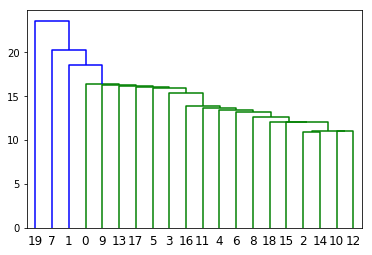

In [22]:
from scipy.cluster.hierarchy import dendrogram, linkage
data = [[0., 0.], [0.1, -0.1], [1., 1.], [1.1, 1.1]]
Z = linkage(dtm_nmf.transpose())
dendrogram(Z,labels=list(range(0,np.shape(dtm_nmf)[1]))) ; 

## TSNE Visualization (NMF)

In [23]:
np.shape(dtm_nmf)

(3896, 20)

In [24]:
tsne_model = TSNE(learning_rate=300,
                  perplexity=50,
                  early_exaggeration=4.0,
                  n_iter=5000,
                  verbose=2,
                  random_state = 101)

tsne_nmf = tsne_model.fit_transform(dtm_nmf)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3896
[t-SNE] Computed conditional probabilities for sample 2000 / 3896
[t-SNE] Computed conditional probabilities for sample 3000 / 3896
[t-SNE] Computed conditional probabilities for sample 3896 / 3896
[t-SNE] Mean sigma: 0.066272
[t-SNE] Iteration 25: error = 1.7255832, gradient norm = 0.0004095
[t-SNE] Iteration 25: gradient norm 0.000409. Finished.
[t-SNE] Iteration 50: error = 1.5616989, gradient norm = 0.0077544
[t-SNE] Iteration 75: error = 1.4555943, gradient norm = 0.0055974
[t-SNE] Iteration 100: error = 1.4325905, gradient norm = 0.0052991
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.432590
[t-SNE] Iteration 125: error = 1.2813141, gradient norm = 0.0035764
[t-SNE] Iteration 150: error = 1.2367276, gradient norm = 0.0032012
[t-SNE] Iteration 175: error = 1.2259429, gradient norm = 0.0031021
[t-SNE] Iteration 

In [25]:
tsne_df = pd.DataFrame(tsne_nmf,columns=['tsne_x','tsne_y'])
tsne_df['robo_group'] = nmf_df['MAX1']
tsne_df['title'] = nmf_df['title']

In [26]:
tsne_df['title'] = tsne_df['title'].str.replace('\n',' ')
tsne_df['title'] = tsne_df['title'].str.replace('.','')
tsne_df['title'] = tsne_df['title'].str.replace('-','_')
tsne_df['title'] = tsne_df['title'].str.replace('[^a-zA-Z0-9\s\_]','')
tsne_df['title'] = tsne_df['title'].str.replace(' ','_')
tsne_df['title'] = tsne_df['title'].str.replace(r'(\_)\1+', r'\1')
tsne_df['title'] = tsne_df['title'].str.replace('_',' ')

In [27]:
tsne_df['paragraphs'] = paragraph_count_df.paragraphs

In [40]:
tsne_df['sponsor'] = laws_summaries['sponsor']
tsne_df['url'] = laws_summaries['url']

In [41]:
tsne_df.to_csv('tsne_data_attemp1.csv')

Color by Topic

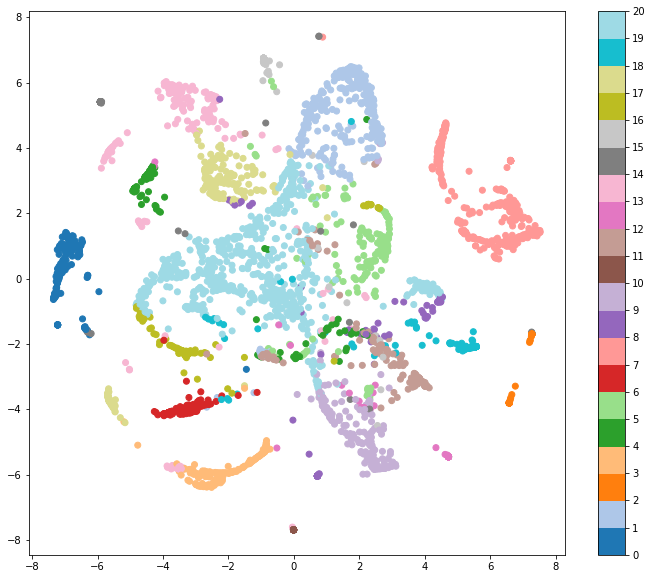

In [30]:
plt.figure(figsize=(12,10))
plt.scatter(tsne_nmf[:,0], 
            tsne_nmf[:,1], 
            c=nmf_df.MAX1, 
            cmap=plt.cm.get_cmap("tab20", num_groups))
plt.colorbar(ticks=range(num_groups+1))
plt.clim(0, num_groups)
plt.show()

Color by Party

In [31]:
c_bar_party = nmf_df['sponsor_party']

m_dict = {'D':0,'R':1}
c_bar_party = c_bar_party.map(m_dict)

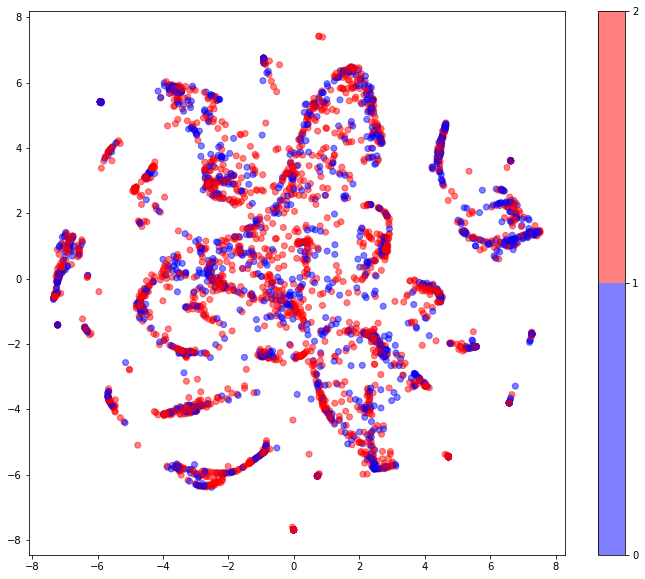

In [32]:
plt.figure(figsize=(12,10))
plt.scatter(tsne_nmf[:,0], 
            tsne_nmf[:,1], 
            c=c_bar_party, 
            cmap=plt.cm.get_cmap("bwr", 2),
           alpha = 0.5)
plt.colorbar(ticks=range(2+1))
plt.clim(0, 2)
plt.show()

Color by state of sponsoring congress person

In [33]:
states = laws_summaries['sponsor_state'].unique()

states_dict = dict()
for ix, s in enumerate(states):
    states_dict[s] = ix
    
num_states = ix + 1

c_bar_state = nmf_df['sponsor_state']
c_bar_state = c_bar_state.map(states_dict)

states_df = pd.DataFrame(list(states_dict.items()),columns=['states','num'])

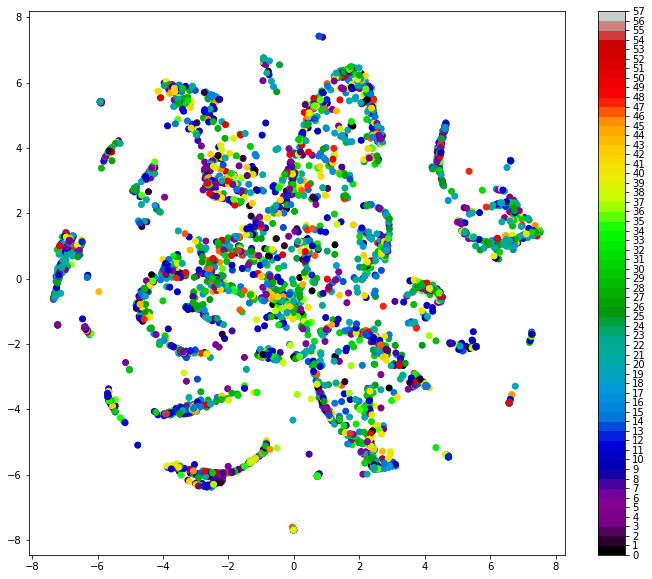

<function matplotlib.pyplot.colorbar>

In [34]:
plt.figure(figsize=(12,10))
plt.scatter(tsne_nmf[:,0],
            tsne_nmf[:,1], 
            c=c_bar_state, 
            cmap=plt.cm.get_cmap("nipy_spectral", num_states))
plt.colorbar(ticks=range(num_states+1))
plt.clim(0, num_states)
plt.show()

plt.colorbar

Color by congressional sessions chronologically

In [35]:
congress = laws_summaries['congress'].unique()

congress_dict = dict()
for ix, c in enumerate(congress):
    congress_dict[c] = ix
    
num_congress = ix + 1

c_bar_congress = nmf_df['congress']
c_bar_congress = c_bar_congress.map(congress_dict)

congress_df = pd.DataFrame(list(congress_dict.items()),columns=['congress','num'])

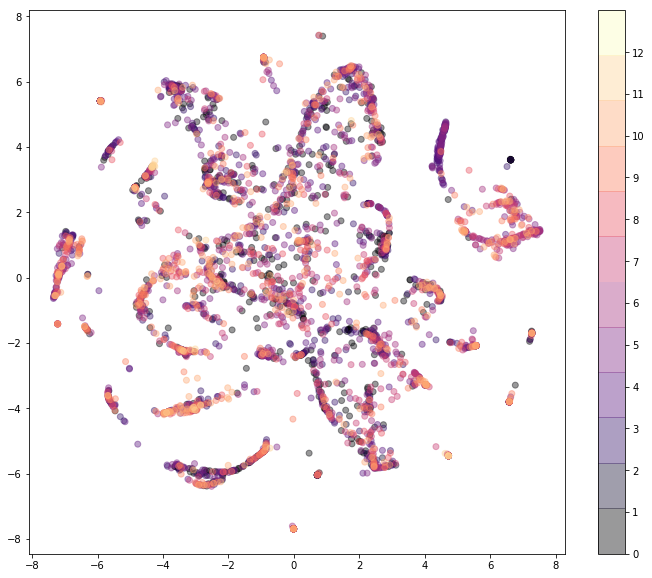

<function matplotlib.pyplot.colorbar>

In [36]:
plt.figure(figsize=(12,10))
plt.scatter(tsne_nmf[:,0],
            tsne_nmf[:,1], 
            c=c_bar_congress, 
            cmap=plt.cm.get_cmap("magma", num_congress),
            alpha = 0.4)
plt.colorbar(ticks=range(num_congress+1))
plt.clim(0, num_congress+1)
plt.show()

plt.colorbar